In [85]:
# Import Librarys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron as SklearnPerceptron, SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from itertools import combinations


import gc

In [64]:
# X is features y is prediction (This for me to remember)
# Set pathing for base and validation sets (CHANGE THESE TO YOUR PATHINGS)
pa_path = r"C:\Users\andre\OneDrive - University of Arkansas\Desktop\Andrew_Branch_ML\project_adult.csv"
pvi_path = r"C:\Users\andre\OneDrive - University of Arkansas\Desktop\Andrew_Branch_ML\project_validation_inputs.csv"
output_path = r"C:\Users\andre\OneDrive - University of Arkansas\Desktop\Andrew_Branch_ML"

# Read the files in
pa = pd.read_csv(pa_path)
pvi = pd.read_csv(pvi_path)


In [65]:
def preprocess_data_label(df):
    # Drop unnamed col
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')

    # Handle missing values
    df = df.dropna()
    df = df[~df.isin(['?']).any(axis=1)]

    # Separate categorical and numeric columns
    cat_cols = df.select_dtypes(include=['object']).columns
    income_col = df['income'].copy()
    cat_cols = cat_cols.drop('income')
    num_cols = df.select_dtypes(exclude=['object']).columns

    # Encode target
    income_col = income_col.map({'<=50K': 0, '>50K': 1})

    # Fit encoders for categorical features
    encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le

    # Fit scaler for numeric features
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    # Final DataFrame
    df = pd.concat([df[num_cols], df[cat_cols], income_col.rename('income')], axis=1)

    X = df.drop(columns=['income'], axis=1).values
    y = df['income'].values.ravel()

    # Return features, target, and the fitted transformers
    return X, y, encoders, scaler

def preprocess_data_validation_label(df, encoders, scaler):
    # Drop unnamed col
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')

    # Handle missing values
    df = df.dropna()
    df = df[~df.isin(['?']).any(axis=1)]

    # Separate categorical and numeric columns
    cat_cols = df.select_dtypes(include=['object']).columns
    num_cols = df.select_dtypes(exclude=['object']).columns

    # Use existing encoders
    for col in cat_cols:
        le = encoders[col]
        # unseen labels will raise error unless handled
        df[col] = df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)

    # Use the same scaler
    df[num_cols] = scaler.transform(df[num_cols])

    # Return only features
    return df[num_cols.tolist() + cat_cols.tolist()].values


In [66]:
class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    self.best_errors_ : Int
        Lowest error found within in epoc training
    self.best_w_ : 1d-array
        Best weights that led to the lowest error
    self.best_b_ : Scalar
        Best bias that lead to the lowest error
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # if you use libarry versions stated by book use float_, else if new use float64
        # self.b_ = np.float_(0.)
        self.b_ = np.float64(0.)

        self.errors_ = []


        # best identifiers
        self.best_errors_ = float('inf')
        self.best_w_ = self.w_.copy()
        self.best_b_ = self.b_

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)

            self.errors_.append(errors)

            if errors < self.best_errors_:
                self.best_errors_ = errors
                self.best_w_ = self.w_
                self.best_b_ = self.b_
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [67]:
class AdalineSGD:
    """ADAptive LInear NEuron classifier (stochastic gradient descent).

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset (epochs).
    shuffle : bool (default: True)
      Shuffles training data every epoch to prevent cycles.
    random_state : int
      Random number generator seed for reproducibility.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared error loss function values in each epoch.

    self.best_misclassifications_  : Int
        Lowest misclassification found within in epoc training
    self.best_w_ : 1d-array
        Best weights that led to the lowest error
    self.best_b_ : Scalar
        Best bias that lead to the lowest error
    """

    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data."""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.)
        self.losses_ = []
        self.errors_ = []

        # best identifiers
        self.best_misclassifications_ = float('inf')
        self.best_w_ = self.w_.copy()
        self.best_b_ = self.b_

        for _ in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)

            losses = []
            for xi, target in zip(X, y):
                loss = self._update_weights(xi, target)
                losses.append(loss)

            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)

            # count misclassifications at the end of each epoch (haha didnt need this. asked for mse for graph)
            y_pred = self.predict(X)
            misclassifications = (y != y_pred).sum()
            if misclassifications < self.best_misclassifications_:
                self.best_misclassifications_ = misclassifications
                self.best_w_ = self.w_.copy()
                self.best_b_ = self.b_

            self.errors_.append(misclassifications)

        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing weights."""
        if not hasattr(self, "w_"):
            self.rgen = np.random.RandomState(self.random_state)
            self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
            self.b_ = np.float64(0.)

        for xi, target in zip(X, y):
            self._update_weights(xi, target)

        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        idx = self.rgen.permutation(len(y))
        return X[idx], y[idx]

    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to a single sample"""
        net_input = self.net_input(xi)
        output = self.activation(net_input)
        error = target - output
        self.w_ += self.eta * 2.0 * xi * error
        self.b_ += self.eta * 2.0 * error
        loss = (error**2).mean()
        return loss

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [113]:
def plot_svm_decision_boundary(X, y, kernel='linear', feature_indices=(0, 1), C=1.0, gamma='scale', max_iter=50000):
    """
    Plot the decision boundary of an SVM for two chosen features.

    Args:
        X (np.ndarray or pd.DataFrame): Feature matrix.
        y (np.ndarray or pd.Series): Target labels.
        kernel (str): SVM kernel ('linear', 'rbf', 'poly', 'sigmoid').
        feature_indices (tuple): Indices of the two features to plot.
        C (float): Regularization parameter.
        gamma (str or float): Kernel coefficient.
    """
    # Ensure X is a DataFrame so we can grab feature names
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
    if isinstance(y, np.ndarray):
        y = pd.Series(y, name="target")

    # Pick chosen features
    f1_idx, f2_idx = feature_indices
    X_pair = X.iloc[:, [f1_idx, f2_idx]]
    f1_name, f2_name = X.columns[f1_idx], X.columns[f2_idx]

    # Encode labels if necessary
    if y.dtype == 'object':
        y = LabelEncoder().fit_transform(y)
    else:
        y = y.to_numpy().ravel()

    # Train SVM
    model = SVC(kernel=kernel, C=C, gamma=gamma, max_iter=max_iter)
    model.fit(X_pair.values, y)

    # Plot points
    plt.scatter(X_pair.iloc[:, 0], X_pair.iloc[:, 1], c=y,
                cmap=plt.cm.coolwarm, s=20, edgecolors='k')

    # Mesh grid for decision boundary
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                         np.linspace(ylim[0], ylim[1], 500))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    # Highlight support vectors
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                s=100, linewidth=1, facecolors='none', edgecolors='k')

    # Labels and title
    plt.xlabel(f1_name)
    plt.ylabel(f2_name)
    plt.title(f"{kernel.capitalize()} ({f1_name} vs {f2_name})")
    plt.show()

In [68]:
def net_input(X, w_, b_):
    """Calculate net input"""
    return np.dot(X, w_) + b_

def activation(X):
    """Compute linear activation"""
    return X

def predict_adaline(X, w_, b_):
    """Return class label after unit step"""
    return np.where(net_input(X, w_, b_) >= 0.0, 1, 0)

def predict_perceptron(X, w_, b_):
    """Return class label after unit step"""
    return np.where(net_input(X, w_, b_) >= 0.5, 1, 0)

In [69]:
# # Apply preprocessing
# X_label, y_label = preprocess_data_label(pa)
# X_label_validation = preprocess_data_validation_label(pvi)

# Training set
X_label, y_label, encoders, scaler = preprocess_data_label(pa)

# Validation/Test set
X_label_validation = preprocess_data_validation_label(pvi, encoders, scaler)

# Split training and test and stratify on y to make sure the split is true and representitive (Would of done cv for algo approach but didnt ): )
X_train, X_test, y_train, y_test = train_test_split(
    X_label, y_label,
    test_size=0.2,
    random_state=42,
    stratify=y_label
)

In [70]:
# Train Perceptron and AdalineSGD to get graphs
ppn = Perceptron(eta=0.1, n_iter=50, random_state=1).fit(X_label, y_label)
ada = AdalineSGD(eta=0.00001, n_iter=50).fit(X_label, y_label)

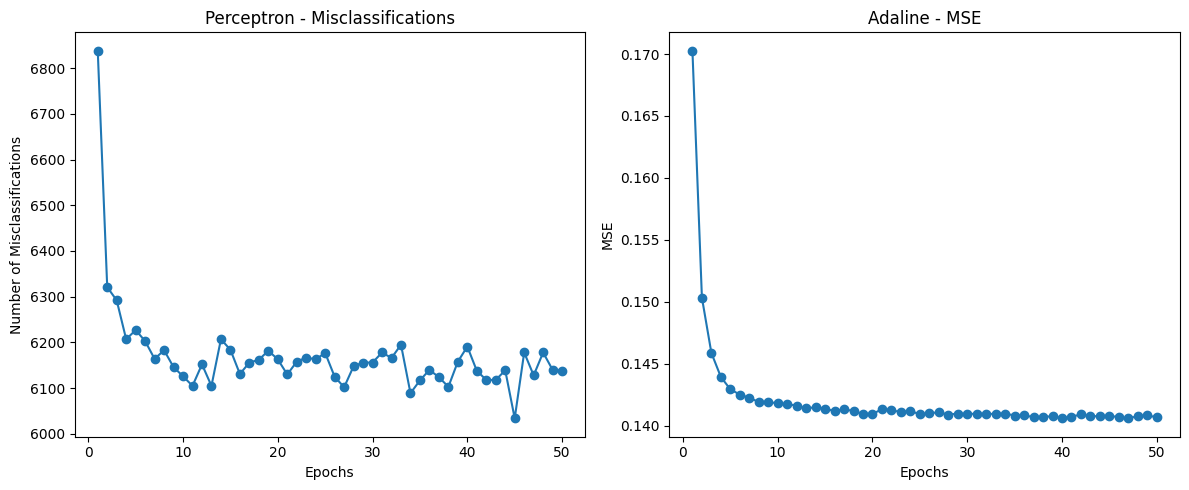

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Perceptron plot
axes[0].plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Number of Misclassifications')
axes[0].set_title('Perceptron - Misclassifications')

# Adaline plot
axes[1].plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('MSE')
axes[1].set_title('Adaline - MSE')

# Adjust layout
plt.tight_layout()
plt.show()

# Graphs plotted show MIS and MSE over epochs converging (Interesting thing found that if you hotcode cat columns for perceptron it doesnt converge. After the first epoch its basically at its lowest MIS. Graph for hotcode isnt shown because one of my friends told me your suppose to label encode it which is what was done part 1)

In [72]:
# Setting up variables to pick the best model for each algo approach using a grid search
best_ppn = None
best_ppn_acc = -1
best_ppn_params = None

best_ada = None
best_ada_acc = -1
best_ada_params = None

# Grid search variables
etas = [0.1, 0.01, 0.001, .0001, .00001]
n_iters = [10, 25, 50]

# Grid search in action below (Basically just storing the paramters that gave me the best accuracy)
for eta in etas:
    for n in n_iters:
        ppn = Perceptron(eta=eta, n_iter=n, random_state=1)
        ppn.fit(X_train, y_train)

        y_pred = ppn.predict(X_test)
        misclassified = (y_test != y_pred).sum()
        accuracy = (len(y_test) - misclassified) / len(y_test)

        if accuracy > best_ppn_acc:
            best_ppn_acc = accuracy
            best_ppn = ppn
            best_ppn_params = (eta, n)
            best_ppn_mis = misclassified

# Grid search in action below (Basically just storing the paramters that gave me the best accuracy)
for eta in etas:
    for n in n_iters:
        ada = AdalineSGD(eta=eta, n_iter=n, random_state=1)
        ada.fit(X_train, y_train)

        y_pred = ada.predict(X_test)
        misclassified = (y_test != y_pred).sum()
        accuracy = (len(y_test) - misclassified) / len(y_test)

        if accuracy > best_ada_acc:
            best_ada_acc = accuracy
            best_ada = ada
            best_ada_params = (eta, n)
            best_ada_mis = misclassified

# Printed evals (Pretty similar, supprising the Adaline model got a little bit lower then perceptron)
print("=== Best Perceptron Model ===")
print(f"Params: eta={best_ppn_params[0]}, n_iter={best_ppn_params[1]}")
print(f"Misclassified={best_ppn_mis}, Accuracy={best_ppn_acc:.4f}")

print("\n=== Best AdalineSGD Model ===")
print(f"Params: eta={best_ada_params[0]}, n_iter={best_ada_params[1]}")
print(f"Misclassified={best_ada_mis}, Accuracy={best_ada_acc:.4f}")

C:\Users\andre\AppData\Local\Temp\ipykernel_35000\1287455499.py:99: RuntimeWarning: overflow encountered in double_scalars
  loss = (error**2).mean()
C:\Users\andre\AppData\Local\Temp\ipykernel_35000\1287455499.py:97: RuntimeWarning: invalid value encountered in multiply
  self.w_ += self.eta * 2.0 * xi * error


=== Best Perceptron Model ===
Params: eta=0.0001, n_iter=50
Misclassified=919, Accuracy=0.8098

=== Best AdalineSGD Model ===
Params: eta=1e-05, n_iter=10
Misclassified=947, Accuracy=0.8040


In [73]:
# Sklearn implementation (This is the ones we use for our final predictions since the accuracys are little higher then the algo approach)

# Setting up param grid to use sklearn GridSearchCV (This is a pretty cool function, didnt relize how easy it was to use)
param_grid = {
    "max_iter": [10, 25, 50, 100],
    "eta0" : [0.1, 0.01, 0.001, .0001, .00001]
}

# Running GridSearchCV with Perceptron (tol=None just has it so it does the full number of iterations instead of stopping when improvement is very little)
grid_ppn = GridSearchCV(
    estimator=SklearnPerceptron(random_state=42, tol=None),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Now actually fitting the perceptron model
grid_ppn.fit(X_label, y_label)

# Printed evals
print("=== Best Scikit-learn Perceptron (GridSearchCV) ===")
print("Best Params:", grid_ppn.best_params_)
print("Best CV Accuracy:", grid_ppn.best_score_, "\n")

# Running GridSearchCV with Adaline (tol=None just has it so it does the full number of iterations instead of stopping when improvement is very little)
grid_ada = GridSearchCV(
    estimator=SGDClassifier(loss='perceptron', learning_rate='constant', random_state=42, tol=None),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Now actually fitting the adaline model
grid_ada.fit(X_label, y_label)

# Printed evals
print("=== Best Scikit-learn Adaline (GridSearchCV) ===")
print("Best Params:", grid_ada.best_params_)
print("Best CV Accuracy:", grid_ada.best_score_)

=== Best Scikit-learn Perceptron (GridSearchCV) ===
Best Params: {'eta0': 0.1, 'max_iter': 100}
Best CV Accuracy: 0.8100766932243608 

=== Best Scikit-learn Adaline (GridSearchCV) ===
Best Params: {'eta0': 0.0001, 'max_iter': 100}
Best CV Accuracy: 0.8095384509671945


In [74]:
# Now using the best models to predict the validation set of data
best_ppn = grid_ppn.best_estimator_
ppn_val_preds_sklearn = best_ppn.predict(X_label_validation)

best_ada = grid_ada.best_estimator_
ada_val_preds_sklearn = best_ada.predict(X_label_validation)

# Convert predictions to DataFrame
ppn_val_preds_df = pd.DataFrame(ppn_val_preds_sklearn, columns=["Prediction"])
ada_val_preds_df = pd.DataFrame(ada_val_preds_sklearn, columns=["Prediction"])

# Save to CSV
ppn_val_preds_df.to_csv(fr"{output_path}\Group_28_Perceptron_PredictedOutputs.csv", index=False)
ada_val_preds_df.to_csv(fr"{output_path}\Group_28_Adaline_PredictedOutputs.csv", index=False)

In [ ]:
# Sklearn implementation (This is the ones we use for our final predictions since the accuracys are little higher then the algo approach)

# Setting up param grid to use sklearn GridSearchCV (This is a pretty cool function, didnt relize how easy it was to use)
param_grid = {
    "max_iter": [10, 25, 50, 100, 500],
    "C" : [.001, .01, .1, 1, 10, 100]
}

# Running GridSearchCV with Perceptron (tol=None just has it so it does the full number of iterations instead of stopping when improvement is very little)
grid_lgr = GridSearchCV(
    estimator=LogisticRegression(solver='lbfgs', random_state=42, penalty='l2'),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Now actually fitting the perceptron model
grid_lgr.fit(X_label, y_label)

# Printed evals
print("=== Best Scikit-learn Perceptron (GridSearchCV) ===")
print("Best Params:", grid_lgr.best_params_)
print("Best CV Accuracy:", grid_lgr.best_score_, "\n")

# Setting up param grid to use sklearn GridSearchCV (This is a pretty cool function, didnt relize how easy it was to use)
param_grid = {
    "max_iter" : [10000, 20000],
    "C" : [.001, .01, .1, 1, 10, 100],
    "kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']

}

# Running GridSearchCV with Perceptron (tol=None just has it so it does the full number of iterations instead of stopping when improvement is very little)
grid_svc = GridSearchCV(
    estimator=SVC(max_iter=-1),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Now actually fitting the perceptron model
grid_svc.fit(X_label, y_label)

# Printed evals
print("=== Best Scikit-learn Perceptron (GridSearchCV) ===")
print("Best Params:", grid_svc.best_params_)
print("Best CV Accuracy:", grid_svc.best_score_, "\n")

In [134]:

# Convert cv_results_ into a DataFrame
lgr_results = pd.DataFrame(grid_lgr.cv_results_)

# Show params + mean test score
print("=== Logistic Regression Results ===")
lgr_results[['params', 'mean_test_score', 'std_test_score']]

=== Logistic Regression Results ===


,params,mean_test_score,std_test_score
0,"{'C': 0.001, 'max_iter': 10}",0.796580,0.003963
1,"{'C': 0.001, 'max_iter': 25}",0.804446,0.004065
2,"{'C': 0.001, 'max_iter': 50}",0.806143,0.004195
3,"{'C': 0.001, 'max_iter': 100}",0.805398,0.004824
4,"{'C': 0.001, 'max_iter': 500}",0.805439,0.004779
5,"{'C': 0.01, 'max_iter': 10}",0.795504,0.003234
6,"{'C': 0.01, 'max_iter': 25}",0.812601,0.002548
7,"{'C': 0.01, 'max_iter': 50}",0.819059,0.003411
8,"{'C': 0.01, 'max_iter': 100}",0.818852,0.004349
9,"{'C': 0.01, 'max_iter': 500}",0.819059,0.004584


In [133]:

svc_results = pd.DataFrame(grid_svc.cv_results_)

print("=== SVC Results ===")
svc_results[['params', 'mean_test_score', 'std_test_score']]


=== SVC Results ===


,params,mean_test_score,std_test_score
0,"{'C': 0.001, 'gamma': 'scale', 'kernel': 'line...",0.796125,0.003897
1,"{'C': 0.001, 'gamma': 'scale', 'kernel': 'line...",0.796125,0.003897
2,"{'C': 0.001, 'gamma': 'scale', 'kernel': 'poly...",0.751252,0.000076
3,"{'C': 0.001, 'gamma': 'scale', 'kernel': 'poly...",0.751252,0.000076
4,"{'C': 0.001, 'gamma': 'scale', 'kernel': 'rbf'...",0.751252,0.000076
...,...,...,...
91,"{'C': 100, 'gamma': 'auto', 'kernel': 'poly', ...",0.540880,0.023122
92,"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf', '...",0.823157,0.002424
93,"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf', '...",0.823198,0.002604
94,"{'C': 100, 'gamma': 'auto', 'kernel': 'sigmoid...",0.708738,0.007957


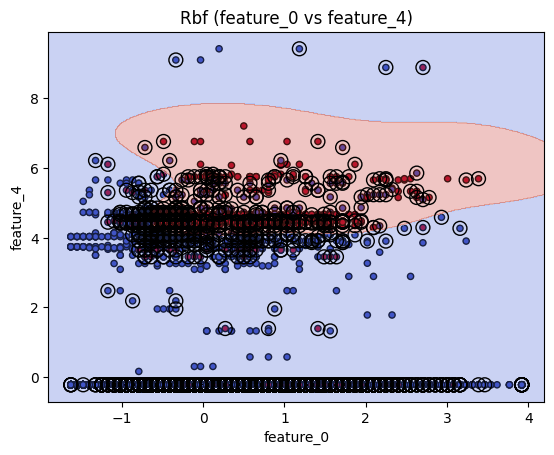

In [127]:
plot_svm_decision_boundary(X_label, y_label, kernel='rbf', feature_indices=(0, 4), C=1.0, gamma='auto', max_iter=50000)



In [128]:
# Now using the best models to predict the validation set of data
best_lgr = grid_lgr.best_estimator_
lgr_val_preds_sklearn = best_lgr.predict(X_label_validation)

best_svc = grid_svc.best_estimator_
svc_val_preds_sklearn = best_svc.predict(X_label_validation)

# Convert predictions to DataFrame
lgr_val_preds_df = pd.DataFrame(lgr_val_preds_sklearn, columns=["Prediction"])
svc_val_preds_df = pd.DataFrame(svc_val_preds_sklearn, columns=["Prediction"])

# Save to CSV
lgr_val_preds_df.to_csv(fr"{output_path}\Group_28_LogisticRegression_PredictedOutputs.csv", index=False)
svc_val_preds_df.to_csv(fr"{output_path}\Group_28_SVM_PredictedOutputs.csv", index=False)

# Reflection and Conceptual Questions

### Why is feature scaling important for gradient-based algorithms
Feature scaling is important due to how gradient based methods work. Gradient updates weights bsaed on the size of the gradient. If a features scale is dramitcally bigger then another it will appear that that feature has huge impact on loss whenever its just due to the scale. The bigger the impact on loss the bigger the gradient is going to be for that change in weight for that feature. Getting everything to the same scale allows Gradient methods to be able to compare appels to appels with the features and update the weights fairly

### Explain the difference between batch gradient descent and stochastic gradient descent

Batch Gradient Descent:
   - Batch works through taking the total loss of all samples in the dataset and then grabbing the gradients for the weights based off the loss and the updating the weights. Then this gets repeated for n epochs until it converges

Stochastic Gradient Descent
   - Stochastic works by taking one sample of the total dataset and using the loss of the one sample to find the gradients and update the weights off of that one sample. This gets repeated until it has itterated through the entire dataset and then gets repeated for n epochs until it converges

### Why does scikit-learn Perceptron and Adline algorithms outperform book code

SKlearn implementations of Perceptron and Adaline outperform the book versions because they are optimized for both speed and stability. They rely on highly efficient vectorized linear algebra operations that scale to large datasets. They also include adaptive learning rate schedules, robust convergence criteria (such as tolerance based stopping), and built-in regularization options (L1, L2, or elastic-net) that improve generalization and prevent overfitting.

### Compare the decision boundaries of logistic regression and SVM

Logistic regression creates a linear decision boundary which in two dimensions is a straight line and in higher dimensions is a hyperplane. It works by maximizing the likelihood of the observed data using a probabilistic model. With the boundary occurring where the predicted probability equals 0.5. This makes logistic regression easy to interpret as coefficients directly reflect how features influence the odds. Support Vector Machines define boundaries based on maximizing the margin from the nearest support vectors. With a linear kernel the boundary is also a straight line but non-linear kernels like RBF or polynomial can create complex curved boundaries making SVM more flexible than logistic regression in handling non-linear data.

### What is the role of regularization in preventing overfitting?

The role of regularization in preventing overfitting through the reduction of blowing up weights massively. Without regularization what can happen is the model will want to put all its value into just a few weights which can be an issue in overfitting the training data. If we want to be able to generalize the model then we need to prevent the model in biasing a small number of features. To do this we add in the loss function a regularization term that basically says that the greater change in weights will increase the loss. This prevents the model in putting a huge amount of bias in just a few weights

### Vary the C values of the scikit-learn LogisticRegression and linear SVC models with [0.01, 1.0, 100.0]

C in SKlearn represents the inverse strength of the regularization term. A lower C means stronger regularization which simplifies the model but can lead to underfitting. As C increases regularization weakens allowing the model to fit the training data more closely which often improves performance up to a point. However, very large C values can cause the model to overfit so the best choice of C balances bias and variance.